In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## A-grid (initial condition spike at h)

In [2]:
nx = 61 # number of points from x = 0 to x = 1
dx = 1/nx

nt = 50
dt = 1/nt

x = np.linspace(0,1,nx)

midpoint = math.floor(math.floor(len(x)/2)/2)*2

initialu = np.zeros(len(x)).astype(float)
initialh = np.where(x == x[midpoint], 1, 0).astype(float)

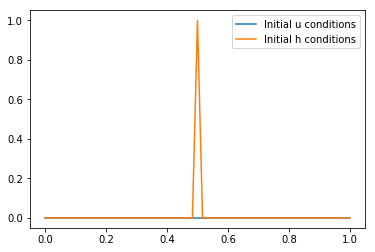

In [3]:
plt.clf()
plt.ion()
plt.plot(x, initialu, label = 'Initial u conditions')
plt.plot(x, initialh, label = 'Initial h conditions')
plt.legend(loc = 'best')
plt.show()

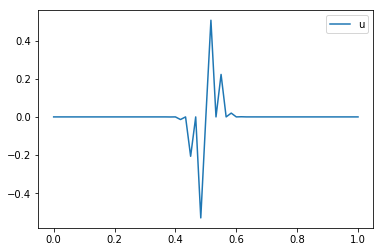

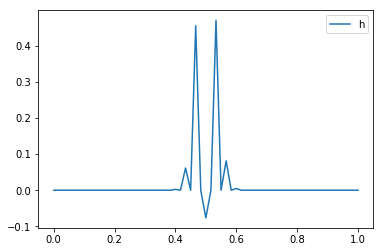

In [11]:
u = initialu.copy()
h = initialh.copy()
uOld = initialu.copy()
hOld = initialh.copy()

g = 1 # gravitational acceleration constant
H = 1 # height

c = 0.1 # courant number root(g*H)(dt/dx)

dt = 1/nt

for it in range(int(nt/2)): 
    for y in range(1, nx-1):
        u[y] = uOld[y] - (c/(2*H))*(hOld[y+1] - hOld[y-1]) # forward in time and centred in space
        h[y] = hOld[y] - (c/(2*g))*(u[y+1] - u[y-1]) # backward in time and centred in space
    hOld = h.copy()
    uOld = u.copy()

plt.ion()
#plt.plot(x, initialu, 'b--', label = 'Initial u conditions')
#plt.plot(x, initialh, 'r--', label = 'Initial h conditions')
plt.plot(x, u, label = 'u')
plt.legend(loc = 'best')
plt.show()

plt.ion()
#plt.plot(x, initialu, 'b--', label = 'Initial u conditions')
#plt.plot(x, initialh, 'r--', label = 'Initial h conditions')
plt.plot(x, h, label = 'h')
plt.legend(loc = 'best')
plt.show()


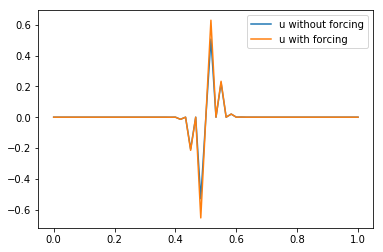

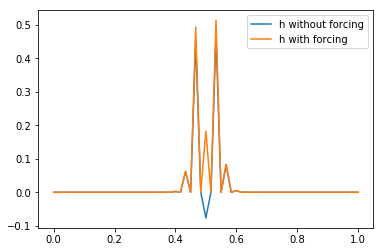

In [12]:
u_forcing = initialu.copy()
h_forcing = initialh.copy()
uOld_forcing = initialu.copy()
hOld_forcing = initialh.copy()

g = 1 # gravitational acceleration constant
H = 1 # height

c = 0.1 # courant number root(g*H)(dt/dx)
w = 8


for it in range(int(nt/2)):   # because looking at t = 0.5
    for y in range(1, nx-1):
        u_forcing[y] = uOld_forcing[y] - (c/(2*H))*(hOld_forcing[y+1] - hOld_forcing[y-1]) # forward in time and centred in space
        if y == midpoint:
            h_forcing[y] = hOld_forcing[y] - (c/(2*g))*(u_forcing[y+1] - u_forcing[y-1]) + dt*math.sqrt(g*H)*math.sin(w*it/(2*nt))# backward in time and centred in space
        else:
            h_forcing[y] = float(hOld_forcing[y] - (c/(2*g))*(u_forcing[y+1] - u_forcing[y-1]))
    hOld_forcing = h_forcing.copy()
    uOld_forcing = u_forcing.copy()

plt.ion()
#plt.plot(x, initialu, 'b--', label = 'Initial u conditions')
#plt.plot(x, initialh, 'r--', label = 'Initial h conditions')
plt.plot(x, u, label = 'u without forcing')
plt.plot(x, u_forcing, label = 'u with forcing')

#plt.plot(x, h, label = 'h')
plt.legend(loc = 'best')
plt.show()

plt.ion()
#plt.plot(x, initialu, 'b--', label = 'Initial u conditions')
#plt.plot(x, initialh, 'r--', label = 'Initial h conditions')
#plt.plot(x, u, label = 'u')
plt.plot(x, h, label = 'h without forcing')
plt.plot(x, h_forcing, label = 'h with forcing')
plt.legend(loc = 'best')
plt.show()

## C-grid

In [ ]:
nx_c = 2*61 # number of points from x = 0 to x = 1

nt = 50


x = np.linspace(0,1,nx_c)
midpoint = math.floor(math.floor(len(x)/2)/2)*2
initialu = np.zeros(len(x)).astype(float)
initialh = np.where(x == x[midpoint], 1, 0).astype(float)

In [ ]:
plt.clf()
plt.ion()
plt.plot(x, initialu, label = 'Initial u conditions')
plt.plot(x, initialh, label = 'Initial h conditions')
plt.legend(loc = 'best')
plt.show()

In [ ]:
u = initialu.copy()
h = initialh.copy()
uOld = initialu.copy()
hOld = initialh.copy()

g = 1 # gravitational acceleration constant
H = 1 # height
w = 8

c = 0.1 # courant number root(g*H)(dt/dx)


for it in range(nt): 
    for y in range(1, math.floor((nx +1)/2)):
        u[2*y + 1] = uOld[2*y + 1] - (c/(2*H))*(hOld[2*y+2] - hOld[2*y]) # forward in time and centred in space
        
        if y == midpoint:
            h[2*y + 2] = hOld[2*y] - (c/(2*g))*(u[2*y + 1] - u[2*y-1]) + dt*math.sqrt(g*H)*math.sin(w*it/(2*nt))# backward in time and centred in space
        else:
            h[2*y + 2] = hOld[2*y] - (c/(2*g))*(u[2*y + 1] - u[2*y-1])
        
    hOld = h.copy()
    uOld = u.copy()

plt.ion()
#plt.plot(x, initialu, 'b--', label = 'Initial u conditions')
#plt.plot(x, initialh, 'r--', label = 'Initial h conditions')
plt.plot(x, u, label = 'u')
plt.plot(x, h, label = 'h')
plt.legend(loc = 'best')
plt.show()